# Анализ популярности научных статей   
  Источник данных: ResearchGate  
Алгоритм:PageRank  

## Описание работы  
#### **Task:**
Собрать (найти) датасет с научными статьями и найти наиболее значимые статьи в каждой области, используя PageRank  
#### **Сбор данных**  
Много времени ушло на поиск подходящего датасета. В результате не было найдено хорошей версии и было решено собирать данные вручную. Остановилась на данных с сайта [ResearchGate](https://www.researchgate.net/).  
Реализован парсер -> тестирование парсера -> обнаружение проблем в парсинге  

### Идея парсинга  
1.Находим статью, у которой большое количество Citations  
2.У текущей статьи перебираем все статьи, которые ссылаются на данную статью (Citations):  
3.Повторяем шаг 2 до тех пор, пока список ссылок не станет пустым

#### Ограничения:  
- по количеству рассматриваемых статей: для каждого направления количество Citations < 11  
Данное ограничение может влиять на результат!  

### Список рассматриваемых научных областей  
1.Mathematics  
2.Biology  
3.Computer Science  
4.Physics  
5.Chemistry  

#### **Проблема**  
Проблема парсинга связана с тем, что при большом количестве обращений к сайту ему кажется, что это робот пытается получить данные, в связи с чем он запроашивает пройти верификацию. Возможно, существуют способы обхода данной проблемы, но я с ними не знакома.  
В связи с возникшей проблемой было принято решение собирать данные вручную.  
Логика сбора данных следующая:    
    1. Ищем популярную статью (на нее ссылается большое количество других статей)  
    2. Собираем данные о данной статье
    3. Собираем список ссылающихся статей и добавляем его в очередь
    4. Повторяем шаги с пункта 2 до тех пор, пока список не пуст  
Сбор данных основан на алгоритме BFS (поиск в ширину). В результате по такому подходу получилось собрать не большое количество данных, но зато получены интересные взаимосвязи между документами: есть те документы, что ссылаются на одну и ту же статью.  
Собранные данные хранятся в папке dataset в формате .csv. 

### Теория вкратце  
Мы исследуем документы и их цитируемость. Для анализа данных в данной работе используется теория графов, с которой связано рассматриваемое понятие **PageRank**.    
PageRank - алгоритм, с помощью которого мы можем определить "важные" документы - такие документы, на которые ссылаются чаще всего другие "выжные" документы. 

### Попытка парсинга

In [257]:
import requests
import numpy as np
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import re, sys, math, random, csv, types, networkx as nx
import operator

In [98]:
parent_link = 'https://www.researchgate.net/'
link = parent_link+'topic/Mathematics/publications?ft=all&rt%5B%5D=ta'

In [99]:
req = requests.get(link)
soup = BeautifulSoup(req.text)

In [100]:
print(soup.prettify())

<!DOCTYPE html>
<html lang="en">
 <head>
  <meta charset="utf-8"/>
  <meta content="text/html; charset=utf-8" http-equiv="content-type"/>
  <meta content="origin" name="referrer"/>
  <meta content="aad-uiM6wbEGQP2hAv5aLZGsBbH/B8k/dqEB1s1aME24pgMbniEUEWFil4asfiI/M16i/LKAq8bJvC+1mVoVoEJD8Rmz/vADuEz8qSxh7vpNfDyFcxBt3ogukR7YG8TA3p4w52cSdw6We5WSrp0N98TPwDZdAb9LAVE4Z3/F2UdBl1Ao3hqIcsIHOUGFRInHHiy8Bh6K6Caz8y5YYMptAIVfbQmTAMYsF9Xspc5ONpbCw9Dy2x8M2V64vrv6pa9Edkl9PaBhqn7LIyG6xQve8nk=" id="Rg-Request-Token" name="Rg-Request-Token"/>
  <meta content="0" http-equiv="expires"/>
  <link as="script" crossorigin="1" href="https://c5.rgstatic.net/m/42455588534132693/javascript/lite/lite.js" rel="preload"/>
  <link href="https://c5.rgstatic.net/m/41542880220916/images/favicon/favicon-32x32.png" rel="icon" sizes="32x32" type="image/png"/>
  <link href="https://www.researchgate.net/favicon-96x96.png" rel="icon" sizes="96x96" type="image/png"/>
  <link href="https://c5.rgstatic.net/m/42134677640462/images/f

In [24]:
articles = soup.find('section', {'class':'lite-page__content'}).findAll('div',{'class','nova-o-stack__item'})

In [95]:
links = []
for article in articles:
    links.append(article.a['href'])

In [96]:
links = links[:len(links)-1]

In [97]:
links

['https://www.researchgate.net/publication/342901857_The_MM--method_on_compact_symmetric_spaces_and_its_applications',
 'https://www.researchgate.net/publication/236682937_An_Interior-Point_Algorithm_for_Linear_Programming_with_Optimal_Selection_of_Centering_Parameter_and_Step_Size',
 'https://www.researchgate.net/publication/344329165_Una_aproximacion_al_conocimiento_didactico-matematico_de_futuros_profesores_de_Educacion_Basica_para_ensenar_matematicas_elementales',
 'https://www.researchgate.net/figure/Example-51-Case-A-t-0000001-x-01-n-1_fig1_346644824',
 'https://www.researchgate.net/figure/Destruction-and-rubble-in-the-war-affected-areas-of-the-city-of-Aleppo-17_fig1_345984550',
 'https://www.researchgate.net/figure/fig1_344672245',
 'https://www.researchgate.net/figure/Essential-components-of-the-Frzilator_fig1_346437549',
 'https://www.researchgate.net/figure/Scatter-plot-comparing-the-experts-and-non-experts-parameter-estimates_fig1_346651361',
 'https://www.researchgate.net/p

In [98]:
#for link in links:
req = requests.get(links[0]+"#citations")
soup = BeautifulSoup(req.text)
citations = soup.find('div',{'class':'js-target-citation'}).findAll('div',{'class':'nova-o-stack__item'})

In [112]:
req = requests.get(links[0]+"#citations")
soup = BeautifulSoup(req.text)
print(soup.find('meta',{'property':'og:title'})['content'][6:])

The (M+,M-)-method on compact symmetric spaces and its applications


In [85]:
citations_links = set()
for citation in citations:
    citations_links.add(parent_link+citation.a['href'])

In [86]:
citations_links

{'https://www.researchgate.net/publication/1765405_Totally_geodesic_submanifolds_of_the_complex_and_the_quaternionic_2-Grassmannians'}

In [69]:
#for link in links:
references = soup.find('div',{'class':'js-target-references'}).findAll('div',{'class':'nova-o-stack__item'})

In [70]:
print(len(references))

21


In [87]:
references_links = set()
for reference in references:
    print(reference)
    if 'publication-citations__load-more' not in reference['class']:
        references_links.add(parent_link+reference.a['href'])

<div class="nova-o-stack__item publication-citations__item publication-citations__item--redesign"><div class="nova-v-citation-item"><div class="nova-o-stack nova-o-stack--gutter-m nova-o-stack--spacing-none nova-o-stack--no-gutter-outside"><div class="nova-o-stack__item"><div class="nova-v-citation-item__context-source"><div class="nova-v-publication-item nova-v-publication-item--size-m gtm-reference-item"><div class="nova-v-publication-item__body"><div class="nova-v-publication-item__stack nova-v-publication-item__stack--gutter-m"><div class="nova-v-publication-item__stack-item"><div class="nova-e-text nova-e-text--size-l nova-e-text--family-sans-serif nova-e-text--spacing-none nova-e-text--color-inherit nova-e-text--clamp-2 nova-v-publication-item__title"><a class="nova-e-link nova-e-link--color-inherit nova-e-link--theme-bare" href="publication/318310609_Two-numbers_and_their_applications_-_A_survey">Two-numbers and their applications - A survey</a></div></div><div class="nova-v-pub

In [84]:
references_links

{'https://www.researchgate.net/publication/274639380_Fixed_point_sets_of_isometries_and_the_intersection_of_real_forms_in_a_Hermitian_symmetric_space_of_compact_type',
 'https://www.researchgate.net/publication/275953799_Estimates_of_antipodal_sets_in_oriented_real_Grassmann_manifolds',
 'https://www.researchgate.net/publication/276896200_The_fixed_point_set_of_a_holomorphic_isometry_the_intersection_of_two_real_forms_in_a_Hermitian_symmetric_space_of_compact_type_and_symmetric_triads',
 'https://www.researchgate.net/publication/282707030_Variational_problems_on_closed_manifolds',
 'https://www.researchgate.net/publication/284596859_A_class_of_groups_in_an_arbitrary_realm_connected_with_the_configuration_of_the_27_lines_on_a_cubic_surface',
 'https://www.researchgate.net/publication/290392460_The_spheres_in_symmetric_spaces',
 'https://www.researchgate.net/publication/305949701_Centrioles_in_Symmetric_Spaces',
 'https://www.researchgate.net/publication/312840636_Transformation_groups_o

In [119]:
#статьи, которые ссылаются на текущую статью
def get_citations(article):
    citations = article.find('div',{'class':'js-target-citation'}).findAll('div',{'class':'nova-o-stack__item'})
    #print(citations)
    citations_links = set()
    for citation in citations:
        if 'publication-citations__load-more' not in citation['class']:
            if citation.a!=None:
                citations_links.add(parent_link+citation.a['href'])
    return citations_links  

In [120]:
#статьи, на которые ссылается текущая статья
def get_references(article):
    references = article.find('div',{'class':'js-target-references'}).findAll('div',{'class':'nova-o-stack__item'})
    references_links = set()
    for reference in references:
        if 'publication-citations__load-more' not in reference['class']:
            if reference.a!=None:
                references_links.add(parent_link+reference.a['href'])
    return references_links  

In [2]:
class Article:
    
    def __init__(self,article_id,title,category,citations, references):
        self.id = article_id;
        self.title = title;
        self.category = category;
        self.citations = citations;
        self.references = references;
        

In [3]:
def get_data(category, N, nodes_count):
    parent_link = 'https://www.researchgate.net/'
    link = parent_link+'topic/'+category+'/publications?ft=all&rt%5B%5D=ta'
    req = requests.get(link)
    soup = BeautifulSoup(req.text)
    #print(soup)
    articles = soup.find('section', {'class':'lite-page__content'}).findAll('div',{'class','nova-o-stack__item'})
    articles = articles[:N]
    links = []
    for article in articles:
        links.append(article.a['href'])
    #links = links[:len(links)-1]
    
    articles_map = dict()
    #перебираем статьи по текущей категории
    articles_map = get_links(links,articles_map,category)
    return articles_map

In [4]:
def get_links(links,articles_map,category):
    if len(articles_map)>100:
        return False
    for current_link in links:
        req = requests.get(current_link)
        article = BeautifulSoup(req.text)
        id = article.find('meta',{'property':'rg:id'})['content'][3:]
        title = article.find('meta',{'property':'og:title'})['content'][6:]
        citations = get_citations(article)
        references = get_references(article)
        print(id,len(citations),len(references))
       # if len(citations) > 0 and len(references) > 0: #???
        articles_map[id] = Article(id,title,category,citations, references)
        articles_map = get_links(citations,articles_map,category)
       # articles_map = get_links(references,articles_map,category)
    return articles_map

### Ошибка

In [150]:
articles_map = get_data('Mathematics', 2, 0)

TypeError: 'NoneType' object is not subscriptable

In [135]:
articles_map['342901857'].citations

{'https://www.researchgate.net/publication/1765405_Totally_geodesic_submanifolds_of_the_complex_and_the_quaternionic_2-Grassmannians'}

In [126]:
articles_map['342901857'].references

{'https://www.researchgate.net/publication/274639380_Fixed_point_sets_of_isometries_and_the_intersection_of_real_forms_in_a_Hermitian_symmetric_space_of_compact_type',
 'https://www.researchgate.net/publication/275953799_Estimates_of_antipodal_sets_in_oriented_real_Grassmann_manifolds',
 'https://www.researchgate.net/publication/276896200_The_fixed_point_set_of_a_holomorphic_isometry_the_intersection_of_two_real_forms_in_a_Hermitian_symmetric_space_of_compact_type_and_symmetric_triads',
 'https://www.researchgate.net/publication/282707030_Variational_problems_on_closed_manifolds',
 'https://www.researchgate.net/publication/284596859_A_class_of_groups_in_an_arbitrary_realm_connected_with_the_configuration_of_the_27_lines_on_a_cubic_surface',
 'https://www.researchgate.net/publication/290392460_The_spheres_in_symmetric_spaces',
 'https://www.researchgate.net/publication/305949701_Centrioles_in_Symmetric_Spaces',
 'https://www.researchgate.net/publication/312840636_Transformation_groups_o

### Ориентированный граф  
узел = статья  
ребро (A,B) = статья A ссылается на статью B  
label = id статьи

In [263]:
################################################################################
### формат данных:
## from - id ссылающихся статей на текущую, to - id статьи, на которую ссылаются
## array, node
################################################################################
def parse_directed(data):
    DG = nx.DiGraph()
    for i, row in enumerate(data):
        node = row[1]
        if node == 'to':
            continue
        DG.add_node(node,pageRank=0,color='blue')
        if row[0] == 'from':
            continue
        neighbours = row[0][1:len(row[0])-1].split(';')
        #print(neighbours)
        for neighbour in neighbours:
            if neighbour!='' and neighbour!='null':
                DG.add_node(neighbour,pageRank=0,color='blue')
                DG.add_edge(neighbour,node)
    return DG

In [262]:
#считывание данных
def parse(filename):
    reader = csv.reader(open(filename, 'r'), delimiter=',')
    data = [row for row in reader]

    return parse_directed(data)


#### Mathematics

In [7]:
math_df = pd.read_csv('dataset/mathematics_data.csv',  # Это то, куда вы скачали файл
                       sep=';', encoding='utf-8')
math_df

,id,title,link
0,1765405,Totally geodesic submanifolds of the complex a...,https://www.researchgate.net/publication/17654...
1,342901857,"The (M+,M-)-method on compact symmetric spaces...",https://www.researchgate.net/publication/34290...
2,346534544,Commuting Jacobi Operators on Real Hypersurfac...,https://www.researchgate.net/publication/34653...
3,328550531,Real hypersurfaces with commuting Jacobi opera...,https://www.researchgate.net/publication/32855...
4,341507449,Homogeneous and inhomogeneous isoparametric hy...,https://www.researchgate.net/publication/34150...
5,339674446,The Index Conjecture for Symmetric Spaces,https://www.researchgate.net/publication/33967...
6,331338889,Submanifold geometry in symmetric spaces of no...,https://www.researchgate.net/publication/33133...
7,330626084,Pseudo-anti commuting Ricci tensor for real hy...,https://www.researchgate.net/publication/33062...
8,320727675,Low-dimensional totally geodesic submanifolds ...,https://www.researchgate.net/publication/32072...
9,327320142,Derivatives of the Shape Operator of Real Hype...,https://www.researchgate.net/publication/32732...


In [105]:
math_graph = parse('dataset/mathematics.csv')

In [9]:
print('количество узлов:',len(math_graph.nodes()))

количество узлов: 40


In [10]:
print('количество ребер:',len(math_graph.edges()))

количество ребер: 43


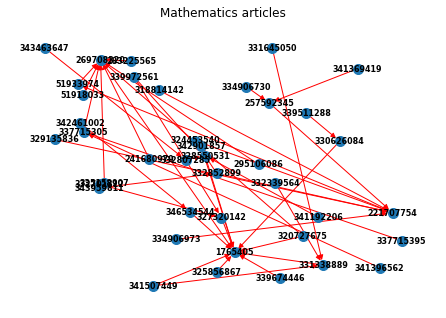

In [11]:
nx.draw_random(math_graph, with_labels=True,font_weight='bold',node_size=100, font_size=8, edge_color='red')
plt.title("Mathematics articles")
plt.show()
plt.savefig('visualization/math_graph.png')
plt.close()

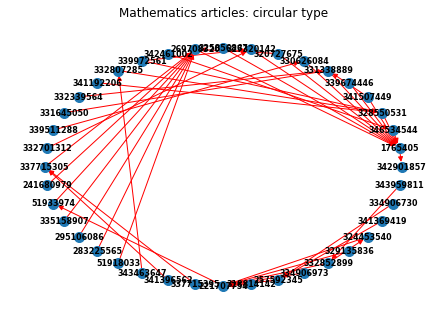

In [12]:
nx.draw_circular(math_graph, with_labels=True,font_weight='bold',node_size=100, font_size=8, edge_color='red')
plt.title("Mathematics articles: circular type")
plt.show()

#### Biology

In [13]:
bio_df = pd.read_csv('dataset/biology_data.csv',  # Это то, куда вы скачали файл
                       sep=';', encoding='utf-8')
bio_df

,id,title,link
0,346510396,Computationally_repurposed_drugs_and_natural_p...,https://www.researchgate.net/publication/34651...
1,344547571,Tackling_COVID-19_Using_Remdesivir_and_Favipir...,https://www.researchgate.net/publication/34454...
2,346555250,epurposing_the_Combination_Drug_of_Favipiravir...,https://www.researchgate.net/publication/34655...
3,348088782,The_find_of_COVID-19_vaccine_Challenges_and_op...,https://www.researchgate.net/publication/34808...
4,344289104,Optimization_of_hydroxychloroquine_dosing_sche...,https://www.researchgate.net/publication/34428...
5,346021874,Microsecond_MD_Simulation_and_Multiple-Conform...,https://www.researchgate.net/publication/34602...
6,347963749,Systematic_Review_on_the_Therapeutic_Options_f...,https://www.researchgate.net/publication/34796...
7,344948317,Knowledge_Attitude_Practice_and_Associated_Fac...,https://www.researchgate.net/publication/34494...
8,344812517,Atuacao_do_fisioterapeuta_na_prevencao_e_trata...,https://www.researchgate.net/publication/34481...
9,344717545,Diagnosis_Challenges_Management_and_Outcome_of...,https://www.researchgate.net/publication/34471...


In [106]:
bio_graph = parse('dataset/biology.csv')

In [70]:
print('количество узлов:',len(bio_graph.nodes()))

количество узлов: 122


In [71]:
print('количество ребер:',len(bio_graph.edges()))

количество ребер: 125


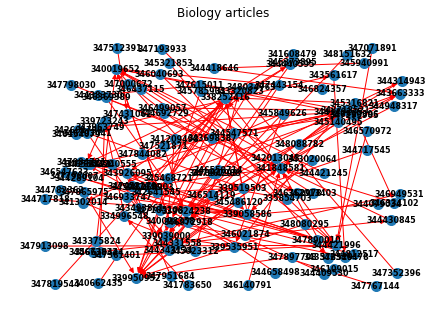

In [72]:
nx.draw_random(bio_graph, with_labels=True,font_weight='bold',node_size=100, font_size=8, edge_color='red')
plt.title("Biology articles")
plt.show()
plt.savefig('visualization/biology_graph.png')
plt.close()

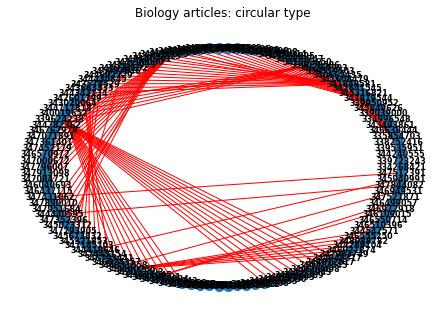

In [73]:
nx.draw_circular(bio_graph, with_labels=True,font_weight='bold',node_size=100, font_size=8, edge_color='red')
plt.title("Biology articles: circular type")
plt.show()

#### Computer Science

In [15]:
cs_df = pd.read_csv('dataset/cs_data.csv',  # Это то, куда вы скачали файл
                       sep=';', encoding='utf-8')
cs_df

,id,title,link
0,304285713,Extending_Scratch_New_pathways_into_programming,https://www.researchgate.net/publication/30428...
1,343425535,DeepScratch_Scratch_Programming_Language_Exten...,https://www.researchgate.net/publication/34342...
2,334963296,ReConstructor_A_Scalable_Constructive_Visualiz...,https://www.researchgate.net/publication/33496...
3,313216105,Scratch_Community_Blocks_Supporting_Children_a...,https://www.researchgate.net/publication/31321...
4,331344416,Entorno_basado_en_programacion_por_bloques_par...,https://www.researchgate.net/publication/33134...
5,320446541,Lessons_in_combining_block-based_and_textual_p...,https://www.researchgate.net/publication/32044...
6,312539174,Proceedings_of_The_Next_Generation_Digital_Lea...,https://www.researchgate.net/publication/31253...
7,334778735,From_Theory_Bias_to_Theory_Dialogue_Embracing_...,https://www.researchgate.net/publication/33477...
8,316652820,Youth_Perspectives_on_Critical_Data_Literacies,https://www.researchgate.net/publication/31665...
9,332747886,Practitioners_Teaching_Data_Science_in_Industr...,https://www.researchgate.net/publication/33274...


In [107]:
cs_graph = parse('dataset/CS.csv')

In [75]:
print('количество узлов:',len(cs_graph.nodes()))

количество узлов: 135


In [76]:
print('количество ребер:',len(cs_graph.edges()))

количество ребер: 158


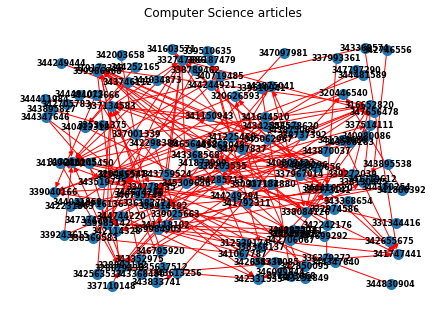

In [77]:
nx.draw_random(cs_graph, with_labels=True,font_weight='bold',node_size=100, font_size=8, edge_color='red')
plt.title("Computer Science articles")
plt.show()
plt.savefig('visualization/CS_graph.png')
plt.close()

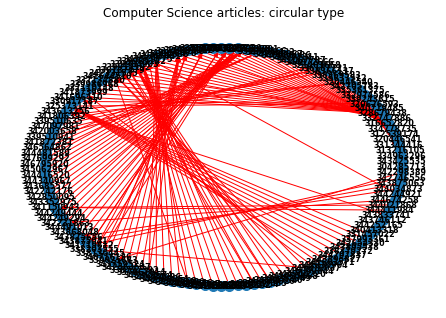

In [78]:
nx.draw_circular(cs_graph, with_labels=True,font_weight='bold',node_size=100, font_size=8, edge_color='red')
plt.title("Computer Science articles: circular type")
plt.show()

#### Physics

In [17]:
ph_df = pd.read_csv('dataset/physics_data.csv', 
                       sep=';', encoding='utf-8')
ph_df

,id,title,link
0,337265949,Semiclassical energy of closed Nambu-Goto strings,https://www.researchgate.net/publication/33726...
1,308692372,The_Quantum_Sine_Gordon_model_in_perturbative_...,https://www.researchgate.net/publication/30869...
2,321719185,Local_nets_of_von_Neumann_algebras_in_the_Sine...,ttps://www.researchgate.net/publication/321719...
3,320867301,Thermal_State_with_Quadratic_Interaction,https://www.researchgate.net/publication/32086...
4,329768751,Reflection_Positivity,https://www.researchgate.net/publication/32976...
5,326646081,The_Status_of_Scaling_Limits_as_Approximations...,https://www.researchgate.net/publication/32664...
6,339778955,A_C-algebraic_Approach_to_Interacting_Quantum_...,https://www.researchgate.net/publication/33977...
7,338923232,The_algebra_of_Wick_polynomials_of_a_scalar_fi...,https://www.researchgate.net/publication/33892...
8,323736638,Wedge-local_observables_for_factorizing_S-matr...,https://www.researchgate.net/publication/32373...
9,311969290,The_Star_Product_in_Interacting_Quantum_Field_...,https://www.researchgate.net/publication/31196...


In [141]:
phscs_graph = parse('dataset/physics.csv')

In [80]:
print('количество узлов:',len(phscs_graph.nodes()))

количество узлов: 53


In [81]:
print('количество ребер:',len(phscs_graph.edges()))

количество ребер: 70


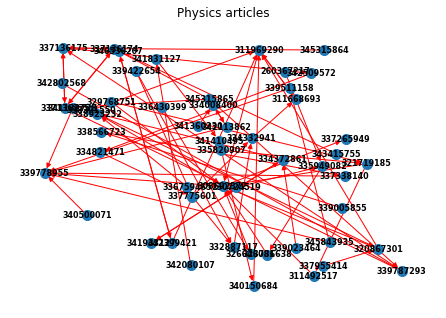

In [82]:
nx.draw_random(phscs_graph, with_labels=True,font_weight='bold',node_size=100, font_size=8, edge_color='red')
plt.title("Physics articles")
plt.show()
plt.savefig('visualization/physics_graph.png')
plt.close()

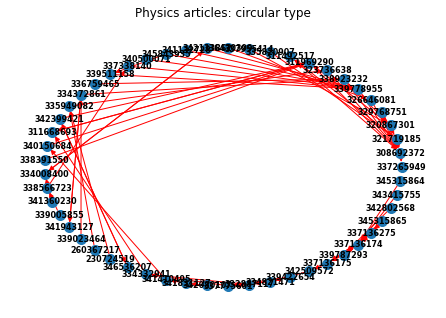

In [84]:
nx.draw_circular(phscs_graph, with_labels=True,font_weight='bold',node_size=100, font_size=8, edge_color='red')
plt.title("Physics articles: circular type")
plt.show()

#### Chemistry

In [19]:
ch_df = pd.read_csv('dataset/chemistry_data.csv', 
                       sep=';', encoding='utf-8')
ch_df

,id,title,link
0,329099920,Visible-Light-Mediated_Synthesis_of_Trifluorom...,https://www.researchgate.net/publication/32909...
1,331390214,Umpolung_Reactivity_of_Fluoroalkylselenotoluen...,https://www.researchgate.net/publication/33139...
2,334806390,Chalcogen_OCF3_Isosteres_Modulate_Drug_Propert...,https://www.researchgate.net/publication/33480...
3,330121714,Use_of_ArSO2SRf_Reagents_An_Efficient_Tool_for...,https://www.researchgate.net/publication/33012...
4,335704753,Fluoroalkylselenolation_of_Alkyl_SilanesTriflu...,https://www.researchgate.net/publication/33570...
5,333725956,Metal-Free_Oxidative_Trifluoromethylselenolati...,https://www.researchgate.net/publication/33372...
6,339661094,Copper-promotedcopper-catalyzed_trifluoromethy...,https://www.researchgate.net/publication/33966...
7,339994253,Metabolic_and_Pharmaceutical_Aspects_of_Fluori...,https://www.researchgate.net/publication/33999...
8,336558134,Thiosulfonates_as_Emerging_Reactants_Synthesis...,https://www.researchgate.net/publication/33655...
9,335821414,Methods_for_the_direct_synthesis_of_thioesters...,https://www.researchgate.net/publication/33582...


In [139]:
chemistry_graph = parse('dataset/chemistry.csv')

In [86]:
print('количество узлов:',len(chemistry_graph.nodes()))

количество узлов: 74


In [87]:
print('количество ребер:',len(chemistry_graph.edges()))

количество ребер: 81


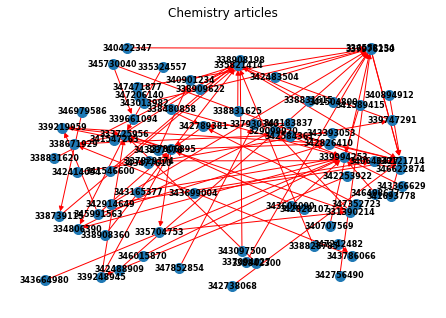

In [88]:
nx.draw_random(chemistry_graph, with_labels=True,font_weight='bold',node_size=100, font_size=8, edge_color='red')
plt.title("Chemistry articles")
plt.show()
plt.savefig('visualization/chemistry_graph.png')
plt.close()

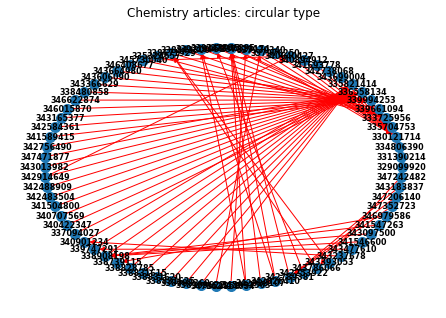

In [89]:
nx.draw_circular(chemistry_graph, with_labels=True,font_weight='bold',node_size=100, font_size=8, edge_color='red')
plt.title("Chemistry articles: circular type")
plt.show()

### PageRank

- один из алгоритмов ссылочного ранжирования, который назначает каждому документу свой так называемый индекс авторитетности (важности страницы), который выражается в виде определенной величины. 

#### Алгоритм  
1.Задаются начальные значения PR для каждого документа  
В качестве начального значения берем 1/N.  
2.Итерация по узлам:    
    2.1.PR(A) = (1-d)/N + d*sum(PR(Bi)/outlinks_count(Bi))


In [21]:
class PageRank:
    def __init__(self, graph):
        self.graph = graph
        self.V_count = len(self.graph)
        self.d = 0.8
        self.ranks = dict()
    
    def rank(self):
        prev = 0
        #начальные значения, PR(A) = 1/N
        for key, node in self.graph.nodes(data=True):
                self.ranks[key] = 1/float(self.V_count)
                prev += self.ranks[key]
        eps = 100
        current = 0
        
        #PR(A) = (1-d)/N + d*sum(PR(Bi)/outlinks_count(Bi))
        while eps > 0.001:
            for key, node in self.graph.nodes(data=True):
                #prev = self.ranks[key]
                rank_sum = 0
                curr_rank = node.get('rank') #берем текущее значение ранга узла
                neighbors = self.graph.out_edges(key) #получаем его соседей
                for n in neighbors:
                    outlinks_count = len(self.graph.out_edges(n[1])) #находим количество исходящих узлов
                    
                    if outlinks_count > 0:
                        rank_sum += (1 / float(outlinks_count)) * self.ranks[n[1]] #второе слагаемое
                #PR(A)
                self.ranks[key] = ((1 - float(self.d)) * (1/float(self.V_count))) + self.d*rank_sum
                current += self.ranks[key]
            eps = abs(current-prev)
            print("PR(t+1)-PR(t) = ", eps)
            prev = current
            current = 0

### Тестирование алгоритма на простом примере

In [7]:
graph_test = parse('dataset/test.csv')

['C']
['A']
['B', 'A']


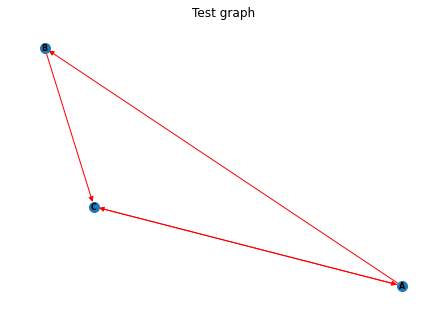

In [49]:
nx.draw_random(graph_test, with_labels=True,font_weight='bold',node_size=100, font_size=8, edge_color='red')
plt.title("Test graph")
plt.show()
plt.close()

In [51]:
pageRank_test = PageRank(graph_test)
pageRank_test.rank()

sorted_rank_test = sorted(pageRank_test.ranks.items(),key=operator.itemgetter(1), reverse=True)

PR(t+1)-PR(t) =  0.21866666666666656
PR(t+1)-PR(t) =  0.0660480000000001
PR(t+1)-PR(t) =  0.03804364799999971
PR(t+1)-PR(t) =  0.021913141248000034
PR(t+1)-PR(t) =  0.012621969358848073
PR(t+1)-PR(t) =  0.007270254350696614
PR(t+1)-PR(t) =  0.004187666506000998
PR(t+1)-PR(t) =  0.002412095907456724
PR(t+1)-PR(t) =  0.0013893672426952275
PR(t+1)-PR(t) =  0.0008002755317921828


In [52]:
sorted_rank_test

[('A', 0.5100660359619246),
 ('B', 0.2832211315078159),
 ('C', 0.2706930810514365)]

### PageRank values

In [110]:
math_pageRank = PageRank(math_graph)
math_pageRank.rank()

math_sorted_rank = sorted(math_pageRank.ranks.items(),key=operator.itemgetter(1), reverse=True)

PR(t+1)-PR(t) =  0.4332960000000008
PR(t+1)-PR(t) =  0.03477503999999998
PR(t+1)-PR(t) =  0.0


In [23]:
math_sorted_rank

[('332852899', 0.030254399999999994),
 ('339972561', 0.019399999999999994),
 ('341369419', 0.018446399999999995),
 ('334906730', 0.018446399999999995),
 ('343959811', 0.017101759999999997),
 ('318814142', 0.016807999999999997),
 ('257592345', 0.016807999999999997),
 ('334906973', 0.016807999999999997),
 ('329135836', 0.016807999999999997),
 ('324453540', 0.016807999999999997),
 ('341507449', 0.0162),
 ('320727675', 0.0162),
 ('343463647', 0.014759999999999997),
 ('341396562', 0.014759999999999997),
 ('337715395', 0.014759999999999997),
 ('221707754', 0.014759999999999997),
 ('342461002', 0.012199999999999997),
 ('332807285', 0.012199999999999997),
 ('341192206', 0.012199999999999997),
 ('332339564', 0.012199999999999997),
 ('331645050', 0.012199999999999997),
 ('339511288', 0.012199999999999997),
 ('332701312', 0.012199999999999997),
 ('337715305', 0.012199999999999997),
 ('241680979', 0.012199999999999997),
 ('51933974', 0.012199999999999997),
 ('335158907', 0.012199999999999997),
 ('

In [111]:
bio_pageRank = PageRank(bio_graph)
bio_pageRank.rank()
bio_sorted_rank = sorted(bio_pageRank.ranks.items(),key=operator.itemgetter(1), reverse=True)
bio_sorted_rank

PR(t+1)-PR(t) =  0.41640687213114747
PR(t+1)-PR(t) =  0.040174373770492044
PR(t+1)-PR(t) =  0.0


[('345849626', 0.008511475409836065),
 ('345987646', 0.007199999999999999),
 ('346154079', 0.006477744262295081),
 ('347615011', 0.006477744262295081),
 ('343561617', 0.0060479999999999996),
 ('344383730', 0.0060479999999999996),
 ('346510396', 0.0060479999999999996),
 ('347521871', 0.0060479999999999996),
 ('347512391', 0.005927134426229508),
 ('343698387', 0.005510819672131147),
 ('342346478', 0.005510819672131147),
 ('347767144', 0.005510819672131147),
 ('344079034', 0.005510819672131147),
 ('347963749', 0.005510819672131147),
 ('346021874', 0.005510819672131147),
 ('344289104', 0.005510819672131147),
 ('348088782', 0.005510819672131147),
 ('346555250', 0.005510819672131147),
 ('344547571', 0.005510819672131147),
 ('346550714', 0.005510819672131147),
 ('346109015', 0.005510819672131147),
 ('346972918', 0.005510819672131147),
 ('346499057', 0.005510819672131147),
 ('346949531', 0.005510819672131147),
 ('345940991', 0.005510819672131147),
 ('346437115', 0.005359737704918033),
 ('34743

In [112]:
CS_pageRank = PageRank(cs_graph)
CS_pageRank.rank()
CS_sorted_rank = sorted(CS_pageRank.ranks.items(),key=operator.itemgetter(1), reverse=True)
CS_sorted_rank

PR(t+1)-PR(t) =  0.37756049382716106
PR(t+1)-PR(t) =  0.03765974913580239
PR(t+1)-PR(t) =  0.0025309032296296774
PR(t+1)-PR(t) =  0.00029725187792595253


[('338084126', 0.013503999999999999),
 ('343868048', 0.010753327407407406),
 ('343519775', 0.009207466666666664),
 ('343870037', 0.007871999999999999),
 ('344797837', 0.007871999999999999),
 ('343875656', 0.007680948148148148),
 ('343875041', 0.007680948148148148),
 ('342114328', 0.007140150992592591),
 ('343368574', 0.006860325925925925),
 ('344347646', 0.006828657777777776),
 ('344150254', 0.006571140740740741),
 ('346578620', 0.006571140740740741),
 ('344072666', 0.006506666666666666),
 ('339985142', 0.006506666666666666),
 ('339984903', 0.006506666666666666),
 ('341747441', 0.006217481481481481),
 ('339914192', 0.006217481481481481),
 ('341067787', 0.005534814814814814),
 ('344252165', 0.0054656),
 ('343746112', 0.0054656),
 ('340413318', 0.0049801481481481485),
 ('344411984', 0.0049801481481481485),
 ('344021868', 0.0049801481481481485),
 ('344674258', 0.0049801481481481485),
 ('342298389', 0.0049801481481481485),
 ('342746556', 0.004951514984296296),
 ('339243615', 0.004799999999

In [142]:
phscs_pageRank = PageRank(phscs_graph)
phscs_pageRank.rank()
phscs_sorted_rank = sorted(phscs_pageRank.ranks.items(),key=operator.itemgetter(1), reverse=True)
phscs_sorted_rank

PR(t+1)-PR(t) =  0.2225242658133333
PR(t+1)-PR(t) =  0.07195989202261344
PR(t+1)-PR(t) =  0.02190425787965855
PR(t+1)-PR(t) =  0.007821453194966521
PR(t+1)-PR(t) =  0.002824174032532323
PR(t+1)-PR(t) =  0.00103698569236077
PR(t+1)-PR(t) =  0.0003897562073316152


[('337136175', 0.03134414225300173),
 ('345315865', 0.028043093923485335),
 ('339422654', 0.02338795093782049),
 ('337775601', 0.023229373061455408),
 ('339787293', 0.02022572904365343),
 ('337136174', 0.02022572904365343),
 ('337136275', 0.02022231445725554),
 ('342399421', 0.01850524392328211),
 ('342113862', 0.01798681024797947),
 ('334372861', 0.01695771447948268),
 ('345843935', 0.016573584905660372),
 ('311969290', 0.014436421248676223),
 ('342509572', 0.014225852209854409),
 ('342080107', 0.014096201713238325),
 ('334821471', 0.01306533413024254),
 ('341831127', 0.012903271009472434),
 ('332887117', 0.012903271009472434),
 ('339005855', 0.012685283018867921),
 ('320867301', 0.012573828447637733),
 ('341360230', 0.01254823210954211),
 ('321719185', 0.01222641509433962),
 ('342802568', 0.011863876523121748),
 ('343415755', 0.011863876523121748),
 ('345315864', 0.011863876523121748),
 ('338923232', 0.011821984209243772),
 ('329768751', 0.011683018867924526),
 ('334332941', 0.011412

In [114]:
chemistry_pageRank = PageRank(chemistry_graph)
chemistry_pageRank.rank()
chemistry_sorted_rank = sorted(chemistry_pageRank.ranks.items(),key=operator.itemgetter(1), reverse=True)
chemistry_sorted_rank

PR(t+1)-PR(t) =  0.49760864864864673
PR(t+1)-PR(t) =  0.0009202162162161853


[('345991563', 0.015698162162162164),
 ('342826410', 0.011212972972972973),
 ('339248945', 0.010789189189189188),
 ('339219959', 0.010789189189189188),
 ('337806895', 0.010486486486486486),
 ('345730040', 0.010486486486486486),
 ('342914649', 0.010486486486486486),
 ('347242482', 0.009085405405405405),
 ('347352723', 0.00822054054054054),
 ('347206140', 0.00822054054054054),
 ('343183837', 0.00822054054054054),
 ('343786066', 0.007978378378378378),
 ('343393053', 0.007978378378378378),
 ('343237678', 0.007978378378378378),
 ('343477610', 0.007978378378378378),
 ('341546600', 0.007978378378378378),
 ('343097500', 0.007978378378378378),
 ('341547263', 0.007978378378378378),
 ('346979586', 0.007978378378378378),
 ('342253922', 0.007018378378378378),
 ('342828107', 0.006897297297297296),
 ('342789381', 0.006897297297297296),
 ('338842300', 0.0065945945945945945),
 ('338671929', 0.0065945945945945945),
 ('335324557', 0.0065945945945945945),
 ('346408677', 0.0065945945945945945),
 ('34366498

In [115]:
math_values = math_sorted_rank[:5]
bio_values = bio_sorted_rank[:5]
cs_values = CS_sorted_rank[:5]
phscs_values = phscs_sorted_rank[:5]
chemistry_values = chemistry_sorted_rank[:5]

### Максимальные значения PageRank для каждой категории

1-Mathematics
2-Biology
3-Computer Science
4-Physics
5-Chemistry


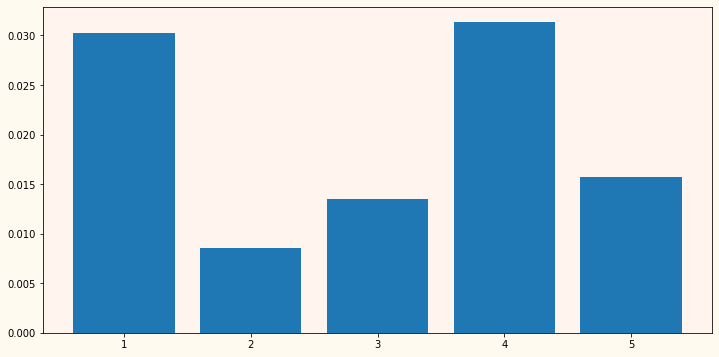

In [261]:
x = [1,2,3,4,5]
y = [math_sorted_rank[0][1],bio_sorted_rank[0][1],CS_sorted_rank[0][1],phscs_sorted_rank[0][1],chemistry_sorted_rank[0][1]]
fig, ax = plt.subplots()
ax.bar(x, y)

ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(12)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure
print('1-Mathematics')
print('2-Biology')
print('3-Computer Science')
print('4-Physics')
print('5-Chemistry')
plt.show()

### Визуализация важности статей  
- красным цветом обозначены центральные документы  
- с помощью размера также выделяется центральность

In [136]:
def set_values(graph,ranks):
    i = 0
    for el in ranks:
        if i < 5:
            graph.nodes[el[0]]['color'] = 'red'
            i+=1
        graph.nodes[el[0]]['pageRank'] = el[1]

In [178]:
set_values(math_graph,math_sorted_rank)
set_values(bio_graph,bio_sorted_rank)
set_values(cs_graph,CS_sorted_rank)
set_values(phscs_graph,phscs_sorted_rank)
set_values(chemistry_graph,chemistry_sorted_rank)

In [242]:
math_data = pd.DataFrame({
     'id': [el[0] for el in math_graph.nodes.data()],
     'PageRank': [el[1]['pageRank'] for el in math_graph.nodes.data()]
 })
math_data = math_data.sort_values(by='PageRank',ascending=False)

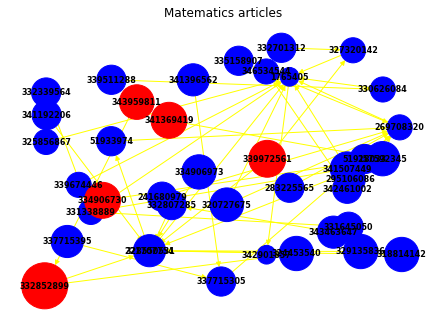

Top 5 articles:
           id  PageRank
34  332852899  0.030254
13  339972561  0.019400
38  334906730  0.018446
37  341369419  0.018446
39  343959811  0.017102 

All values:
           id  PageRank
34  332852899  0.030254
13  339972561  0.019400
38  334906730  0.018446
37  341369419  0.018446
39  343959811  0.017102
31  318814142  0.016808
33  334906973  0.016808
32  257592345  0.016808
35  329135836  0.016808
36  324453540  0.016808
8   320727675  0.016200
4   341507449  0.016200
30  221707754  0.014760
29  337715395  0.014760
28  341396562  0.014760
27  343463647  0.014760
22   51933974  0.012200
26   51918033  0.012200
25  283225565  0.012200
24  295106086  0.012200
23  335158907  0.012200
20  337715305  0.012200
21  241680979  0.012200
19  332701312  0.012200
18  339511288  0.012200
17  331645050  0.012200
16  332339564  0.012200
15  341192206  0.012200
14  332807285  0.012200
12  342461002  0.012200
6   331338889  0.009000
2   346534544  0.009000
3   328550531  0.009000
5   339674

In [182]:
nx.draw_random(math_graph, with_labels=True,node_color=[el[1]['color'] for el in math_graph.nodes.data()],
               font_weight='bold',node_size=[el[1]['pageRank']*70000 for el in math_graph.nodes.data()], font_size=8, edge_color='yellow')
plt.title("Matematics articles")
plt.show()
print('Top 5 articles:')
print(math_data[:5],'\n')
print('All values:')
print(math_data)
plt.close()

In [183]:
bio_data = pd.DataFrame({
     'id': [el[0] for el in bio_graph.nodes.data()],
     'PageRank': [el[1]['pageRank'] for el in bio_graph.nodes.data()]
 })
bio_data = bio_data.sort_values(by='PageRank',ascending=False)

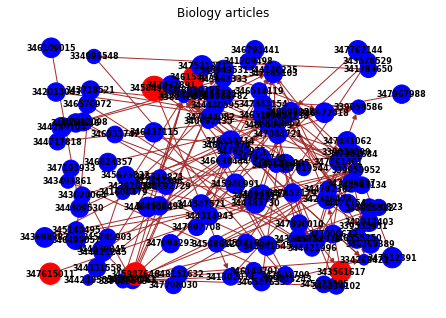

Top 5 articles:
           id  PageRank
10  345849626  0.008511
43  345987646  0.007200
93  346154079  0.006478
95  347615011  0.006478
92  343561617  0.006048 

All values:
            id  PageRank
10   345849626  0.008511
43   345987646  0.007200
93   346154079  0.006478
95   347615011  0.006478
92   343561617  0.006048
94   344383730  0.006048
117  347521871  0.006048
112  346510396  0.006048
121  347512391  0.005927
113  346550714  0.005511
106  347963749  0.005511
120  345940991  0.005511
88   343698387  0.005511
114  346109015  0.005511
90   347767144  0.005511
91   344079034  0.005511
118  346949531  0.005511
116  346499057  0.005511
89   342346478  0.005511
108  344289104  0.005511
107  346021874  0.005511
111  344547571  0.005511
110  346555250  0.005511
109  348088782  0.005511
115  346972918  0.005511
119  347844082  0.005360
66   347431062  0.005360
65   346437115  0.005360
14   342641545  0.005311
74   345321853  0.004839
..         ...       ...
44   344692729  0.004000
4

In [185]:
nx.draw_random(bio_graph, with_labels=True,node_color=[el[1]['color'] for el in bio_graph.nodes.data()],
               font_weight='bold',node_size=[el[1]['pageRank']*70000 for el in bio_graph.nodes.data()], font_size=8, edge_color='brown')
plt.title("Biology articles")
plt.show()
print('Top 5 articles:')
print(bio_data[:5],'\n')
print('All values:')
print(bio_data)
plt.close()

In [186]:
cs_data = pd.DataFrame({
     'id': [el[0] for el in cs_graph.nodes.data()],
     'PageRank': [el[1]['pageRank'] for el in cs_graph.nodes.data()]
 })
cs_data = cs_data.sort_values(by='PageRank',ascending=False)

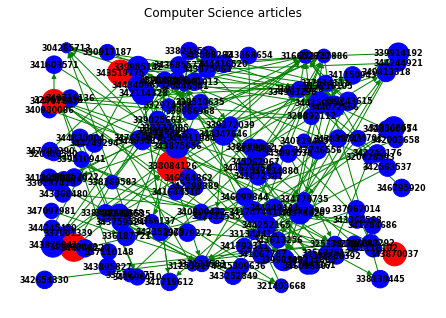

Top 5 articles:
            id  PageRank
33   338084126  0.013504
80   343868048  0.010753
43   343519775  0.009207
117  344797837  0.007872
113  343870037  0.007872 

All values:
            id  PageRank
33   338084126  0.013504
80   343868048  0.010753
43   343519775  0.009207
117  344797837  0.007872
113  343870037  0.007872
81   343875656  0.007681
82   343875041  0.007681
34   342114328  0.007140
92   343368574  0.006860
97   344347646  0.006829
105  344150254  0.006571
107  346578620  0.006571
23   344072666  0.006507
44   339985142  0.006507
45   339984903  0.006507
42   341747441  0.006217
46   339914192  0.006217
24   341067787  0.005535
125  343746112  0.005466
124  344252165  0.005466
134  342298389  0.004980
128  344021868  0.004980
127  344411984  0.004980
123  340413318  0.004980
129  344674258  0.004980
133  342746556  0.004952
13   339243615  0.004800
21   336187721  0.004800
132  343875063  0.004554
131  344034873  0.004554
..         ...       ...
47   336187479  0.00

In [188]:
nx.draw_random(cs_graph, with_labels=True,node_color=[el[1]['color'] for el in cs_graph.nodes.data()],
                 font_weight='bold',node_size=[el[1]['pageRank']*70000 for el in cs_graph.nodes.data()], font_size=8, edge_color='green')
plt.title("Computer Science articles")
plt.show()
print('Top 5 articles:')
print(cs_data[:5],'\n')
print('All values:')
print(cs_data)
plt.close()

In [170]:
ph_data = pd.DataFrame({
     'id': [el[0] for el in phscs_graph.nodes.data()],
     'PageRank': [el[1]['pageRank'] for el in phscs_graph.nodes.data()]
 })
ph_data = ph_data.sort_values(by='PageRank',ascending=False)

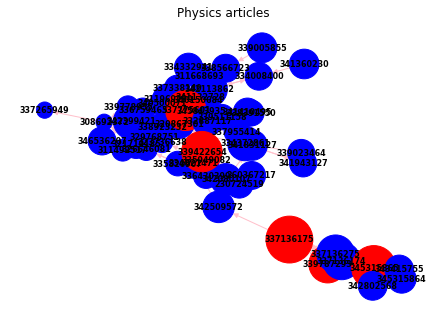

Top 5 articles:
           id  PageRank
45  337136175  0.031344
49  345315865  0.028043
43  339422654  0.023388
40  337775601  0.023229
46  339787293  0.020226 

All values:
           id  PageRank
45  337136175  0.031344
49  345315865  0.028043
43  339422654  0.023388
40  337775601  0.023229
46  339787293  0.020226
47  337136174  0.020226
48  337136275  0.020222
23  342399421  0.018505
14  342113862  0.017987
21  334372861  0.016958
16  345843935  0.016574
9   311969290  0.014436
44  342509572  0.014226
39  342080107  0.014096
42  334821471  0.013065
38  341831127  0.012903
41  332887117  0.012903
30  339005855  0.012685
3   320867301  0.012574
29  341360230  0.012548
2   321719185  0.012226
52  345315864  0.011864
50  342802568  0.011864
51  343415755  0.011864
7   338923232  0.011822
4   329768751  0.011683
37  341410495  0.011412
36  334332941  0.011412
35  346536207  0.011176
28  338566723  0.011140
33  260367217  0.011140
34  230724519  0.011140
27  334008400  0.010968
31  341943

In [175]:
nx.draw_spring(phscs_graph, node_color=[el[1]['color'] for el in phscs_graph.nodes.data()], with_labels=True,font_weight='bold',node_size=[el[1]['pageRank']*70000 for el in phscs_graph.nodes.data()], font_size=8, edge_color='pink')
plt.title("Physics articles")
plt.show()
print('Top 5 articles:')
print(ph_data[:5],'\n')
print('All values:')
print(ph_data)
plt.close()

In [189]:
ch_data = pd.DataFrame({
     'id': [el[0] for el in chemistry_graph.nodes.data()],
     'PageRank': [el[1]['pageRank'] for el in chemistry_graph.nodes.data()]
 })
ch_data = ch_data.sort_values(by='PageRank',ascending=False)

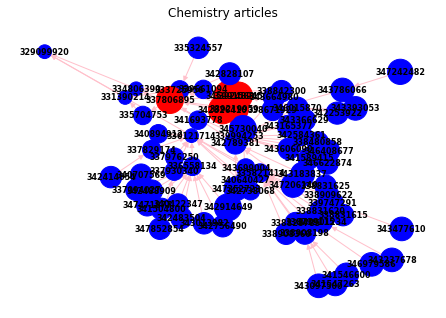

Top 5 articles:
           id  PageRank
57  345991563  0.015698
59  342826410  0.011213
19  339248945  0.010789
20  339219959  0.010789
24  345730040  0.010486 

All values:
           id  PageRank
57  345991563  0.015698
59  342826410  0.011213
19  339248945  0.010789
20  339219959  0.010789
24  345730040  0.010486
18  337806895  0.010486
38  342914649  0.010486
73  347242482  0.009085
72  343183837  0.008221
71  347206140  0.008221
70  347352723  0.008221
68  341547263  0.007978
66  341546600  0.007978
69  346979586  0.007978
67  343097500  0.007978
62  343786066  0.007978
63  343393053  0.007978
64  343237678  0.007978
65  343477610  0.007978
61  342253922  0.007018
60  342789381  0.006897
58  342828107  0.006897
48  338739115  0.006595
41  341504800  0.006595
42  340707569  0.006595
43  340422347  0.006595
44  337094027  0.006595
45  340901234  0.006595
46  339747291  0.006595
47  338908198  0.006595
..        ...       ...
23  335324557  0.006595
25  346408677  0.006595
26  343664

In [190]:
nx.draw_spring(chemistry_graph, with_labels=True,node_color=[el[1]['color'] for el in chemistry_graph.nodes.data()],
               font_weight='bold',node_size=[el[1]['pageRank']*70000 for el in chemistry_graph.nodes.data()], font_size=8, edge_color='pink')
plt.title("Chemistry articles")
plt.show()
print('Top 5 articles:')
print(ch_data[:5],'\n')
print('All values:')
print(ch_data)
plt.close()

In [244]:
math_data

,id,PageRank
34,332852899,0.030254
13,339972561,0.019400
38,334906730,0.018446
37,341369419,0.018446
39,343959811,0.017102
31,318814142,0.016808
33,334906973,0.016808
32,257592345,0.016808
35,329135836,0.016808
36,324453540,0.016808


### Популярные статьи по математике  

In [253]:
print('1.'," ".join(math_df.loc[math_df['id'] == 332852899]['title'].values[0].split("_")))
print('2.'," ".join(math_df.loc[math_df['id'] == 339972561]['title'].values[0].split("_")))
print('3.'," ".join(math_df.loc[math_df['id'] == 334906730]['title'].values[0].split("_")))
print('4.'," ".join(math_df.loc[math_df['id'] == 341369419]['title'].values[0].split("_")))
print('5.'," ".join(math_df.loc[math_df['id'] == 343959811]['title'].values[0].split("_")))

1. A DDVV Type Inequality and a Pinching Theorem for Compact Minimal Submanifolds in a Generalized Cylinder $$\mathbb {S}^{n 1}(c)\times \mathbb {R}^{n 2}$$ S n 1 ( c ) × R n 2
2. Commuting Jacobi operators on Real hypersurfaces of Type B in the complex quadric
3. The Basic Equations of a Submanifold
4. Totally umbilical submanifolds in pseudo-Riemannian space forms
5. A Pinching Theorem for Compact Minimal Submanifolds in Warped Products I×fSm(c)


### Популярные статьи по биологии

In [252]:
print('1.'," ".join(bio_df.loc[bio_df['id'] == 345849626]['title'].values[0].split("_")))
print('2.'," ".join(bio_df.loc[bio_df['id'] == 345987646]['title'].values[0].split("_")))
print('3.'," ".join(bio_df.loc[bio_df['id'] == 346154079]['title'].values[0].split("_")))
print('4.'," ".join(bio_df.loc[bio_df['id'] == 347615011]['title'].values[0].split("_")))
print('5.'," ".join(bio_df.loc[bio_df['id'] == 343561617]['title'].values[0].split("_")))

1. Explainable Machine Learning for Early Assessment of COVID-19 Risk Prediction in Emergency Departments
2. New Rod-Like H-Bonded Assembly Systems Mesomorphic and Geometrical Aspects
3. The therapeutic importance of acid-base balance
4. Challenges and Opportunities from Targeting Inflammatory Responses to SARS-CoV-2 Infection A Narrative Review
5. Proton Pump Inhibitors are Risk Factors for Viral Infections Even for COVID-19


### Популярные статьи по CS

In [254]:
print('1.'," ".join(cs_df.loc[cs_df['id'] == 338084126]['title'].values[0].split("_")))
print('2.'," ".join(cs_df.loc[cs_df['id'] == 343868048]['title'].values[0].split("_")))
print('3.'," ".join(cs_df.loc[cs_df['id'] == 343519775]['title'].values[0].split("_")))
print('4.'," ".join(cs_df.loc[cs_df['id'] == 344797837]['title'].values[0].split("_")))
print('5.'," ".join(cs_df.loc[cs_df['id'] == 343870037]['title'].values[0].split("_")))

1. Situating Data Science Exploring How Relationships to Data Shape Learning
2. Research Methods in Learning Design and Technology
3. Learning Machine Learning with Personal Data Helps Stakeholders Ground Advocacy Arguments in Model Mechanics
4. Visual narratives of global politics in the digital age an introduction
5. Relating Spatial Skills and Expression Evaluation


### Популярные статьи по физике

In [255]:
print('1.'," ".join(ph_df.loc[ph_df['id'] == 337136175]['title'].values[0].split("_")))
print('2.'," ".join(ph_df.loc[ph_df['id'] == 345315865]['title'].values[0].split("_")))
print('3.'," ".join(ph_df.loc[ph_df['id'] == 339422654]['title'].values[0].split("_")))
print('4.'," ".join(ph_df.loc[ph_df['id'] == 337775601]['title'].values[0].split("_")))
print('5.'," ".join(ph_df.loc[ph_df['id'] == 339787293]['title'].values[0].split("_")))

1. Isolated systems and their symmetries part II local and global symmetries of field theories
2. Angular momentum without rotation turbocharging relationalism
3. Homological perspective on edge modes in linear Yang-Mills and Chern-Simons theory
4. Linear Yang-Mills Theory as a Homotopy AQFT
5. Gauge-invariance and the empirical significance of symmetries


### Популярные статьи по химии

In [256]:
print('1.'," ".join(ch_df.loc[ch_df['id'] == 345991563]['title'].values[0].split("_")))
print('2.'," ".join(ch_df.loc[ch_df['id'] == 342826410]['title'].values[0].split("_")))
print('3.'," ".join(ch_df.loc[ch_df['id'] == 339248945]['title'].values[0].split("_")))
print('4.'," ".join(ch_df.loc[ch_df['id'] == 339219959]['title'].values[0].split("_")))
print('5.'," ".join(ch_df.loc[ch_df['id'] == 345730040]['title'].values[0].split("_")))

1. Markovnikov-Type Hydrotrifluoromethylchalcogenation of Unactivated Terminal Alkenes with Me4NXCF3 X S Se and TfOH
2. CaCl 2 -Promoted Dehydroxytrifluoromethylselenolation of Alcohols with Me 4 NSeCF 3
3. Quaternary Ammonium Trifluoromethoxide Salts as Stable Sources of Nucleophilic OCF 3
4. Oxidative Trifluoromethylselenolation of 13-Dicarbonyls with Me4NSeCF3
5. New visible light organometal-photocatalyzed fluoroalkylsulfanylation RFS- and fluoroalkylselenolation RFSe- reactions of organic substrates


### Вывод  
В ходе проделанной работы было выявлено, что алгоритм **PageRank** является достаточно простым и понятным, помогает выделить интересные статьи, что потом можно использовать/используется при отображении самых полезных научных статей.  На сайте ResearchGate не было найдено такой функциональности, как отображение наиболее популярных статей (список сортируется по дате добавления: от новых к старым). Следовательно, данный алгоритм можно было бы применить к этому сайту для быстрого поиска хороших статей.   
**P.S.** Честно говоря, мне самой было трудно искать хорошие статьи при начале сбора данных в связи с отсутствием данной возможности на сайте